<a href="https://colab.research.google.com/github/pri538/NP-Projects/blob/main/Emotion_Detection_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
train_df = pd.read_csv("/content/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

test_df = pd.read_csv("/content/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("/content/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [ ]:
train_df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
train_df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
train_df.label.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

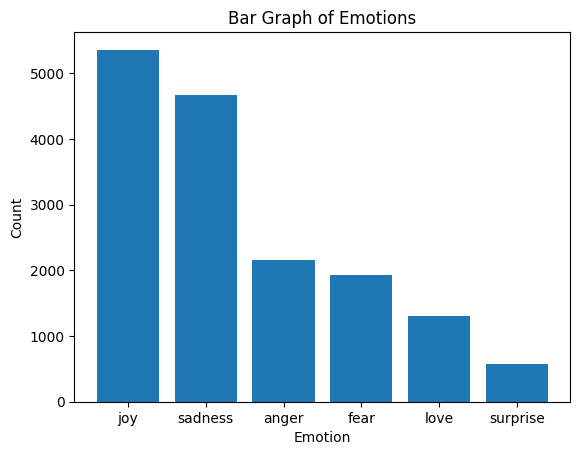

In [ ]:
# Get the data
emotions_count = train_df['label'].value_counts()
emotions = emotions_count.index.to_list()
counts = emotions_count.to_list()

# Create the bar chart
plt.bar(emotions, counts)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Bar Graph of Emotions')
plt.show()

In [ ]:
train_df = train_df[~train_df['label'].isin(['fear', 'surprise'])]
test_df = test_df[~test_df['label'].isin(['fear', 'surprise'])]
val_df = val_df[~val_df['label'].isin(['fear', 'surprise'])]

In [ ]:
train_df['label'].unique()

array(['sadness', 'anger', 'love', 'joy'], dtype=object)

In [ ]:
# Create a mapping dictionary based on the 'label' column for renaming
mapping = {'anger': 'Anger', 'love': 'Calmness', 'joy': 'Happiness', 'sadness': 'Sadness'}

# Rename the columns using the mapping dictionary
train_df["label"] = train_df['label'].map(mapping)
test_df["label"] = test_df['label'].map(mapping)
val_df["label"] = val_df['label'].map(mapping)

<ipython-input-9-5c7c1fdc68b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df['label'].map(mapping)


In [ ]:
train_df['label'].unique()

array(['Sadness', 'Anger', 'Calmness', 'Happiness'], dtype=object)

In [ ]:
test_df['label'].unique()

array(['Sadness', 'Happiness', 'Anger', 'Calmness'], dtype=object)

In [ ]:
val_df['label'].unique()

array(['Sadness', 'Calmness', 'Anger', 'Happiness'], dtype=object)

In [ ]:
tr_text = train_df['sentence']
tr_label = train_df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = test_df['sentence']
ts_label = test_df['label']

In [ ]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

In [ ]:
max_words = 10000
max_len = 50
embedding_dim = 64

In [ ]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [ ]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 50)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 50, 64)               640000    ['embedding_input[0][0]']     
                                                                                              

In [ ]:
batch_size = 128
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
106/106 [==============================] - 11s 70ms/step - loss: 1.4559 - accuracy: 0.3709 - precision: 0.3808 - recall: 0.1434 - val_loss: 1.3715 - val_accuracy: 0.3679 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
106/106 [==============================] - 8s 75ms/step - loss: 1.2514 - accuracy: 0.4258 - precision: 0.5134 - recall: 0.1068 - val_loss: 1.3604 - val_accuracy: 0.4687 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
106/106 [==============================] - 7s 67ms/step - loss: 1.2059 - accuracy: 0.4623 - precision: 0.5874 - recall: 0.1797 - val_loss: 1.3455 - val_accuracy: 0.4815 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
106/106 [==============================] - 8s 75ms/step - loss: 1.1283 - accuracy: 0.5215 - precision: 0.6651 - recall: 0.2800 - val_loss: 1.2780 - val_accuracy: 0.6005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
106/106 [==============================] - 6s 57ms/step 

In [ ]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

54/54 [==============================] - 0s 6ms/step - loss: 0.1594 - accuracy: 0.9398 - precision: 0.9457 - recall: 0.9368
Loss: 0.16, Accuracy: 0.94, Precision: 0.95, Recall: 0.94


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

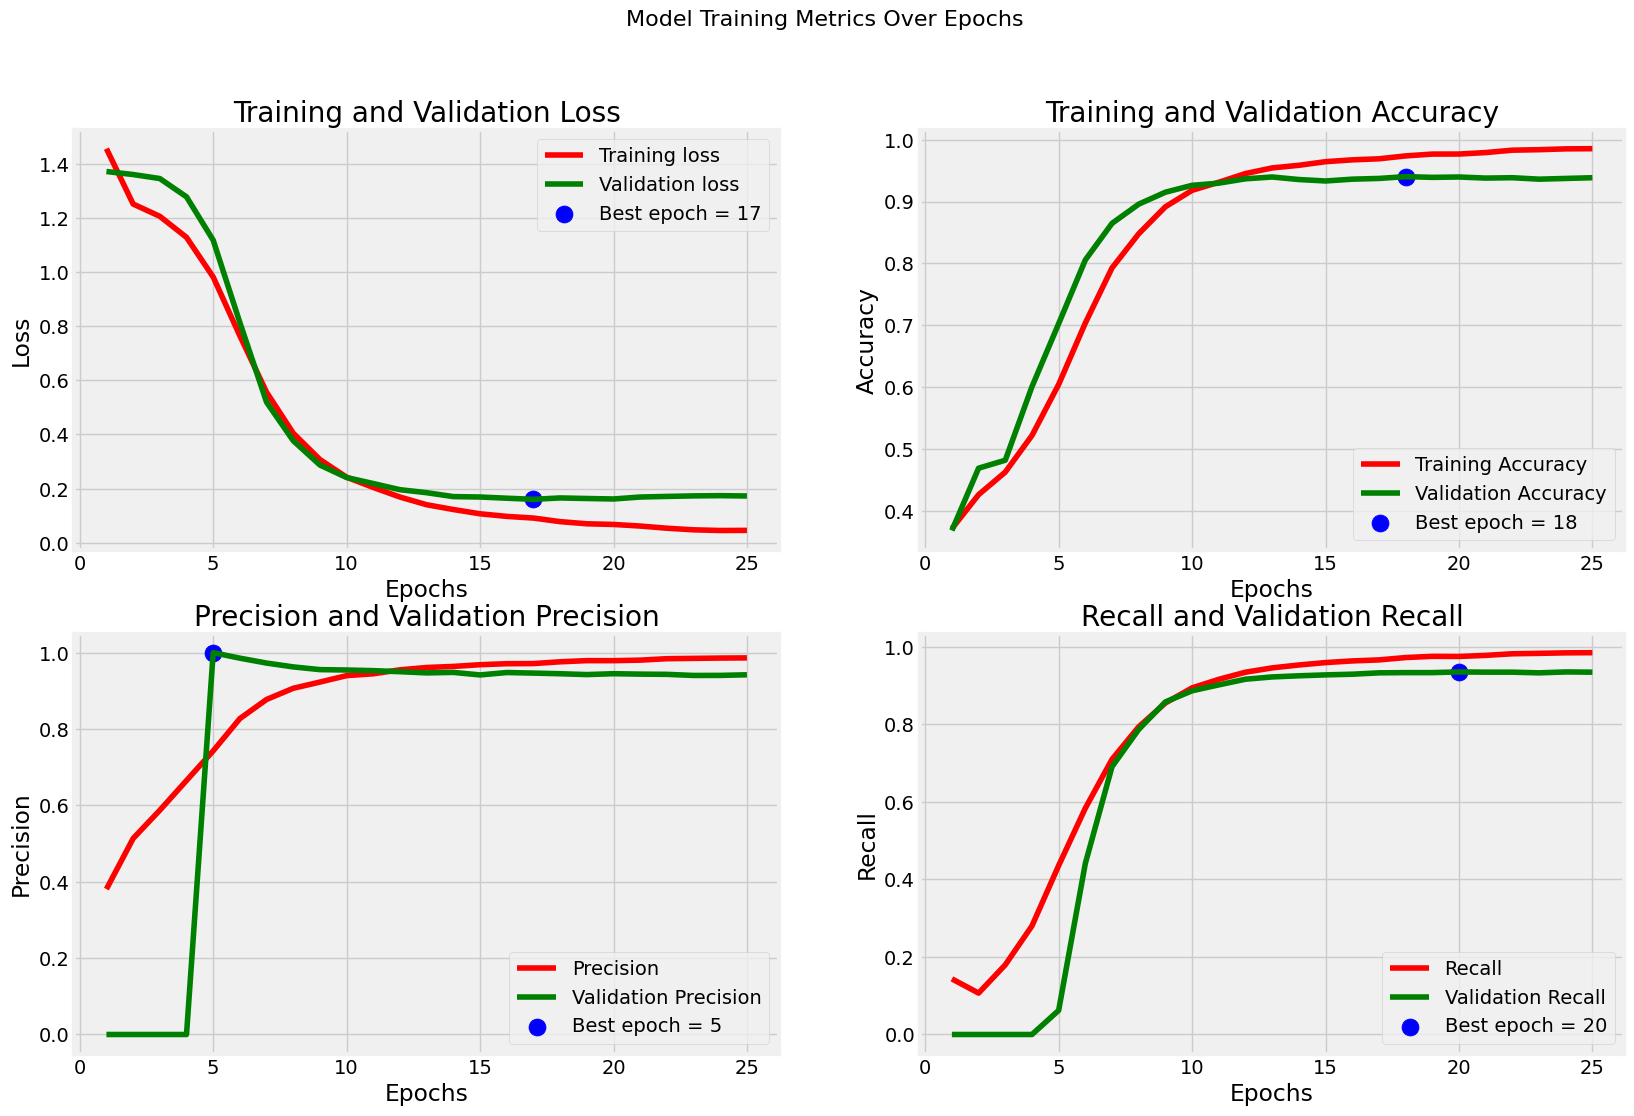

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
y_true=[]
for i in range(len(ts_y)):
    x = np.argmax(ts_y[i])
    y_true.append(x)

In [ ]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

54/54 [==============================] - 0s 3ms/step


array([3, 3, 3, ..., 0, 2, 2])

<Axes: >

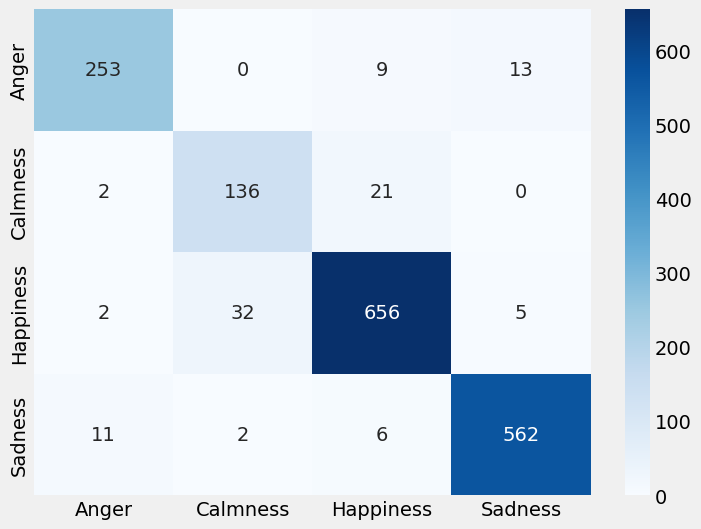

In [ ]:
plt.figure(figsize=(8,6))
emotions = {0: 'Anger', 1: 'Calmness', 2: 'Happiness', 3:'Sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [ ]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       275
           1       0.80      0.86      0.83       159
           2       0.95      0.94      0.95       695
           3       0.97      0.97      0.97       581

    accuracy                           0.94      1710
   macro avg       0.92      0.92      0.92      1710
weighted avg       0.94      0.94      0.94      1710



In [ ]:
import pickle

# tokenizer file for prediction
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# encoder file for classes
with open('encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

# Keras Model
model.save('nlp_model.keras')

# H5 Model
model.save('nlp_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
